In [121]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [122]:
def show(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')  # hide axes
    plt.show()


In [123]:
def find_corners(image):
    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define yellow range (tune if needed)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Create mask
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the biggest contour (assuming it’s your rectangle)
    c = max(contours, key=cv2.contourArea)

    # Approximate contour to polygon
    epsilon = 0.02 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)
    
    if len(approx) == 4:
        corners = approx.reshape(4, 2)  # 4 corner points
        return corners, c
    else:
        print("Not a rectangle detected!")

def black_in_contour_upper_lower(image, contour, v_threshold=50):
    """
    Determine if blackish pixels in the original image are more in the upper or lower half of a given contour.

    Args:
        image (np.ndarray): Original color image (BGR).
        contour (np.ndarray): Contour (from cv2.findContours).
        v_threshold (int): Threshold for blackish pixels using HSV V channel.

    Returns:
        str: 'upper', 'lower', or 'equal' depending on which half has more black pixels.
        int: Number of black pixels in upper half of contour.
        int: Number of black pixels in lower half of contour.
    """
    # Create empty mask same size as image
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Fill the contour area with white
    cv2.drawContours(mask, [contour], -1, 255, thickness=-1)

    # Convert original image to HSV and extract V channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    V = hsv[:, :, 2]

    # Blackish pixels
    black_area = (V < v_threshold)

    # Apply contour mask
    black_in_contour = black_area & (mask == 255)

    # Find bounding box of contour
    x, y, w, h = cv2.boundingRect(contour)
    upper_half = black_in_contour[y:y+h//2, x:x+w]
    lower_half = black_in_contour[y+h//2:y+h, x:x+w]

    black_upper = np.sum(upper_half)
    black_lower = np.sum(lower_half)

    if black_upper > black_lower:
        result = "upper"
    elif black_lower > black_upper:
        result = "lower"
    else:
        result = "equal"

    return result, black_upper, black_lower


def grow_mask(mask, growth_pixels=5):
    """
    Grow the white areas of a binary mask by a given number of pixels.

    Args:
        mask (np.ndarray): Binary mask (0 = background, 255 = foreground).
        growth_pixels (int): Number of pixels to grow in all directions.

    Returns:
        np.ndarray: New grown mask.
    """
    # Create a square kernel of size (2*growth_pixels + 1)
    kernel_size = 2 * growth_pixels + 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Dilate the mask
    grown_mask = cv2.dilate(mask, kernel, iterations=1)

    return grown_mask

### New idea: finding the corners

In [124]:
image_grid = cv2.imread("/user/christoph.wald/u15287/big-scratch/00_uncropped_dataset/YSTohneInsekten/IMG_5886.JPG")
#image_grid = cv2.rotate(image_grid, cv2.ROTATE_180)
image_objects = cv2.imread("/user/christoph.wald/u15287/big-scratch/02_splitted_data/train_labeled/images_uncropped/BRAIIM_0003.jpg")

 
corners_grid, _ = find_corners(image_grid)
corners_object, c = find_corners(image_objects)

In [126]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    return rect

corners_grid = order_points(corners_grid)
corners_object = order_points(corners_object)

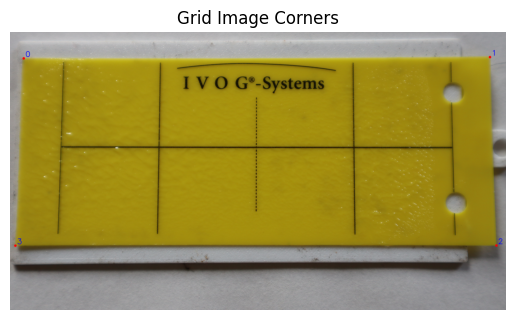

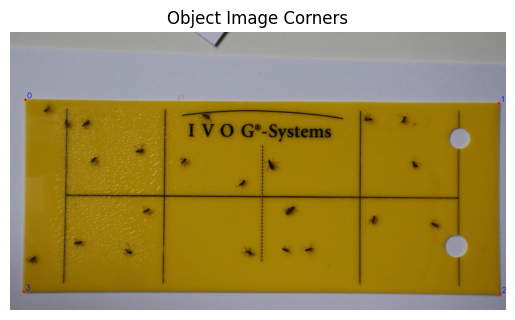

In [127]:
def draw_corners(img, corners, name="Corners"):
    vis = img.copy()
    for i, (x, y) in enumerate(corners.astype(int)):
        cv2.circle(vis, (x, y), 15, (0, 0, 255), -1)  # red dot
        cv2.putText(vis, str(i), (x+20, y-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,0), 6)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.axis("off")
    plt.show()

draw_corners(image_grid, corners_grid, "Grid Image Corners")
draw_corners(image_objects, corners_object, "Object Image Corners")

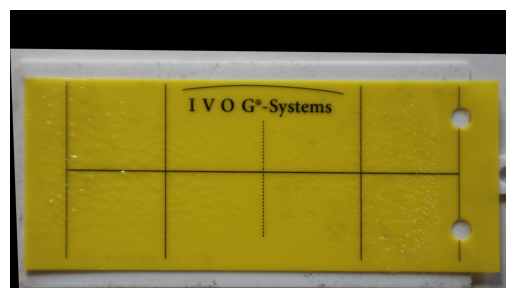

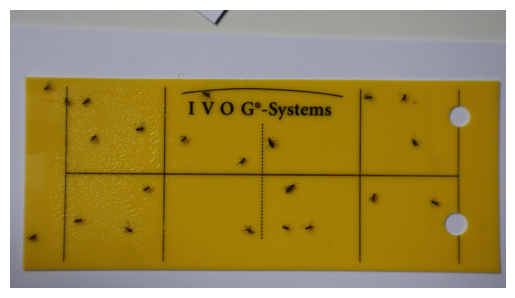

In [128]:
# corners from grid image
pts_grid = np.float32(corners_grid)

# corners from object image
pts_object = np.float32(corners_object)

# Compute homography
H, _ = cv2.findHomography(pts_grid, pts_object, cv2.RANSAC)

# Warp grid
aligned_grid = cv2.warpPerspective(image_grid, H, (image_objects.shape[1], image_objects.shape[0]))


show(aligned_grid)
show(image_objects)

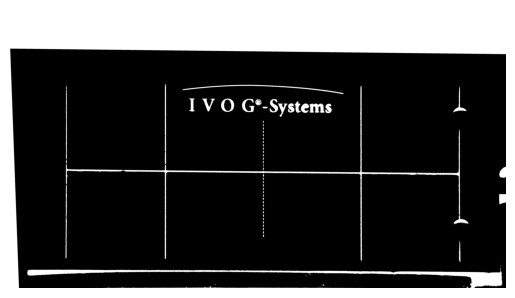

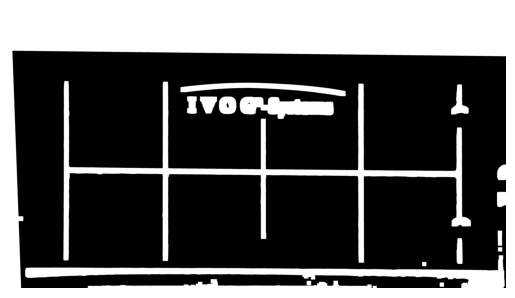

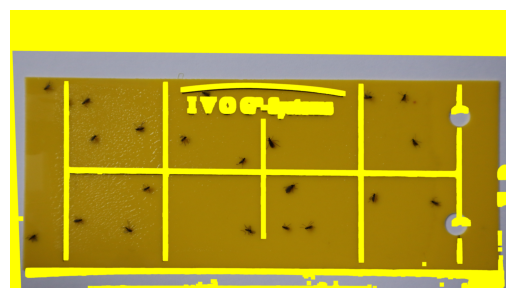

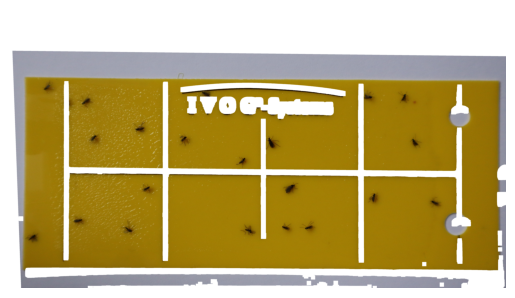

In [129]:
# Convert aligned grid to grayscale
gray_grid = cv2.cvtColor(aligned_grid, cv2.COLOR_BGR2GRAY)

# Threshold: make grid lines white
_, grid_mask = cv2.threshold(gray_grid, 90, 255, cv2.THRESH_BINARY_INV)

show(grid_mask)
grid_mask = grow_mask(grid_mask, growth_pixels=25)
show(grid_mask)

# Make a white 3-channel image
white_layer = np.ones_like(image_objects) * 255

# Where the grid mask is white, take from the white layer
# Where it's black, keep the object image
object_with_white_grid = np.where(grid_mask[..., None] == 255, white_layer, image_objects)

# Create a solid yellow layer (same size as image2)
yellow_layer = np.zeros_like(image_objects)
yellow_layer[:] = (0, 255, 255)   # BGR for yellow

# Where the grid mask is white, take from yellow layer
# Where it's black, keep the object image
object_with_yellow_grid = np.where(grid_mask[..., None] == 255, yellow_layer, image_objects)

# Show result
plt.imshow(cv2.cvtColor(object_with_yellow_grid, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Show result
plt.imshow(cv2.cvtColor(object_with_white_grid, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()



### Testing segmentation

In [130]:
def create_binary_mask(image):
    '''
    binary masking with manual set threshold (yellow) taken from the checkpot-project
    '''
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return mask
def scale_rect(x, y, w, h, scale):
    """
    Scales a rectangle around its center.
    """
    # Center of original rectangle
    cx = x + w / 2
    cy = y + h / 2

    # New width and height
    new_w = w * scale
    new_h = h * scale

    # New top-left corner
    new_x = cx - new_w / 2
    new_y = cy - new_h / 2

    return int(new_x), int(new_y), int(new_w), int(new_h)

def draw_bounding_boxes(image, min_area, max_area, scale = 2, max_ratio = 2):

    inverted_mask = cv2.bitwise_not(create_binary_mask(image))  # Invert the mask to get contours on the foreground
    
    contours, _ = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    counter = 0

    for contour in contours:
        contour_area = cv2.contourArea(contour)
        
        if min_area <= contour_area <= max_area:
            counter += 1
            x, y, w, h = cv2.boundingRect(contour)
            x,y,w,h = scale_rect(x,y,w,h, scale) #scaling, because the contour misses fine details
            if w == 0 or h == 0:
                continue
            ratio = max(w, h) / min(w, h) #calculating ratio to filter out rectangles not "square enough"
            if ratio <= max_ratio:
                cv2.rectangle(image, (x, y), (x + w, y + h), (255), thickness=2)
                
    print(f"{counter} bounding boxes found.")
    return image

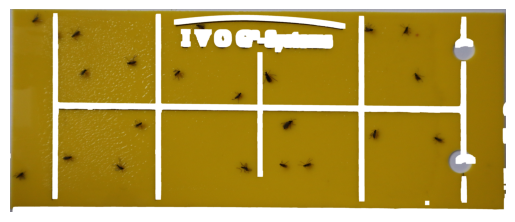

In [131]:
x, y, w, h = cv2.boundingRect(c)
cropped_image = object_with_white_grid[y:y+h, x:x+w]
show(cropped_image)

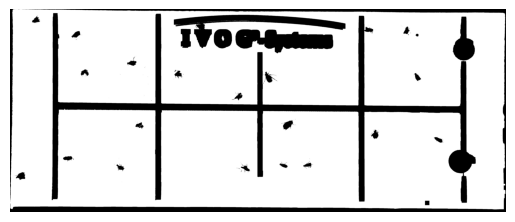

In [132]:
show(create_binary_mask(cropped_image))

20 bounding boxes found.


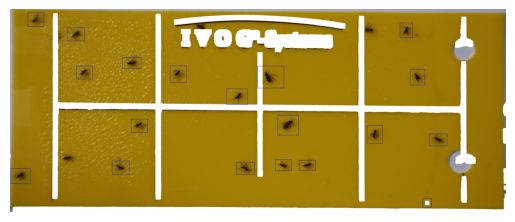

In [ ]:
min_area = 1000  # Define your minimum contour area
max_area = 10000  # Define your maximum contour area
show(draw_bounding_boxes(cropped_image, min_area, max_area))

In [134]:
cropped_image.shape

(2363, 5775, 3)

In [135]:
preprocessed_image = cv2.imread("/user/christoph.wald/u15287/big-scratch/01_dataset/images/FungusGnats/BRAIIM_0001.jpg")

In [136]:
preprocessed_image.shape

(2359, 5789, 3)